**Draw bounding boxes in images**

In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pathlib
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
import os
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [121]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

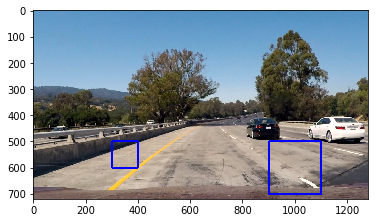

In [122]:
%matplotlib inline
# Test the function on one of the test images provided
image = mpimg.imread('./test_images/test1.jpg')

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((300, 500), (400, 600)), ((900, 500), (1100, 700))]

result = draw_boxes(image, bboxes)
plt.imshow(result)


**Template Matching**

In [189]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    for template in templist:
        temp = mpimg.imread(template)
        templ = np.copy(temp)
        method = eval('cv2.TM_CCOEFF')
        #print(templ.shape)
        w, h = templ.shape[1], templ.shape[0]
        res = cv2.matchTemplate(img, templ, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
    # Read in templates one by one
    # Use cv2.matchTemplate() to search the image
    #     using whichever of the OpenCV search methods you prefer
    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    return bbox_list

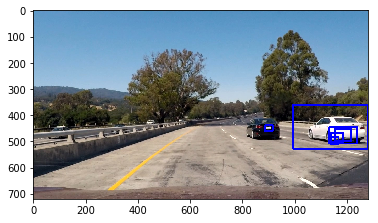

In [190]:
image = mpimg.imread('./test_images/test1.jpg')
#image = mpimg.imread('./test_images/test2.jpg')
templist = ['./cutouts/cutout1.jpg', './cutouts/cutout2.jpg', './cutouts/cutout3.jpg',
            './cutouts/cutout4.jpg', './cutouts/cutout5.jpg', './cutouts/cutout6.jpg']


bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

**Histograms of Color**

In [191]:
# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = bin_edges[1:] + bin_edges[0:len(bin_edges)-1]/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [192]:
# Define a function to compute normalised color histogram features
def color_hist1(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist, bin_edges = np.histogram(image[:,:,0], bins=nbins, density=True)#, range=bins_range, density=True)
    rhist = rhist * np.diff(bin_edges)
    ghist, bin_edges = np.histogram(image[:,:,1], bins=nbins, density=True)#, range=bins_range, density=True)
    ghist = ghist * np.diff(bin_edges)
    bhist, bin_edges = np.histogram(image[:,:,2], bins=nbins, density=True)#, range=bins_range, density=True)
    bhist = bhist * np.diff(bin_edges)
    # Generating bin centers
    #bin_edges = rhist[1]
    #bin_centers = bin_edges[1:] + bin_edges[0:len(bin_edges)-1]/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist, ghist, bhist))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

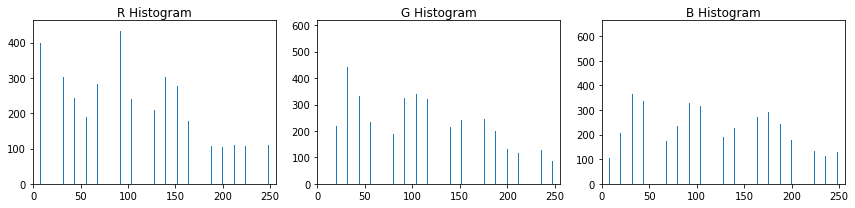

In [193]:
image = mpimg.imread('./cutouts/cutout1.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

**Spatial Binning of Color**

In [194]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # if values have 255 as maximum, scale them to [0,1]
    if np.amax(features) > 1:
        features = features * 1. / 255
    # Return the feature vector
    return features

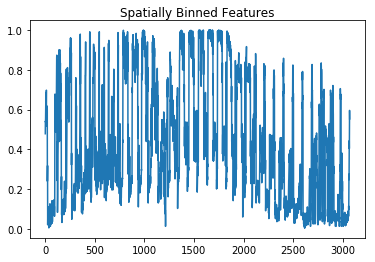

In [199]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('./cutouts/cutout1.jpg')

    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

**Data Exploration**

In [130]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    car_image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = car_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_image.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


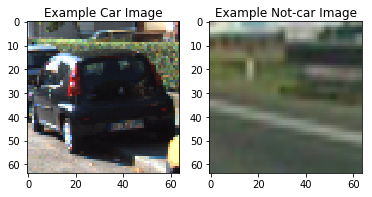

In [131]:
# Read non-vehicles and vehicles images
notcars = glob.glob('non-vehicles/*/*.png')
cars = glob.glob('vehicles/*/*.png')
        
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

**HOG Features**

In [132]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        #features = [] # Remove this line
        #hog_image = img # Remove this line
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        # Use skimage.hog() to get features only
        #features = [] # Remove this line
        return features

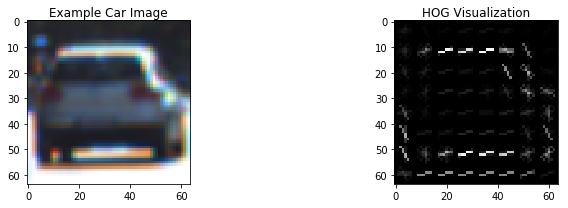

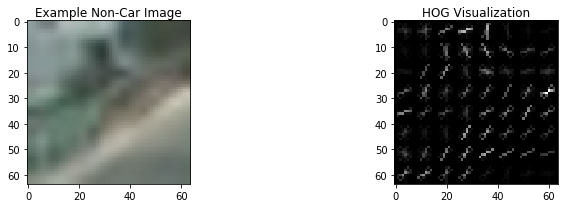

In [188]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image1 = mpimg.imread(notcars[ind])
gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
# (Non-car images)
features1, hog_image1 = get_hog_features(gray1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(12,3))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Example Car Image')
plt.subplot(122), plt.imshow(hog_image, cmap='gray'), plt.title('HOG Visualization')
fig.tight_layout()
fig = plt.figure(figsize=(12,3))
plt.subplot(121), plt.imshow(image1, cmap='gray'), plt.title('Example Non-Car Image')
plt.subplot(122), plt.imshow(hog_image1, cmap='gray'), plt.title('HOG Visualization')
fig.tight_layout()


**Combine and Normalize Features**

In [134]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist1(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
27.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9932
Pickle size: 271698


(<matplotlib.axes._subplots.AxesSubplot at 0x120c56080>,
 <matplotlib.text.Text at 0x125fc3a58>)

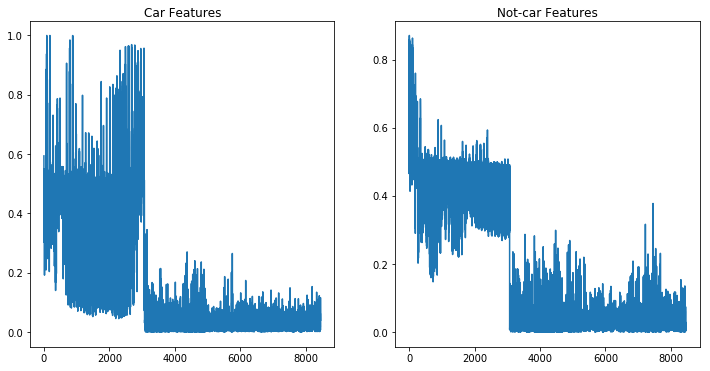

In [200]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save svc and parameters to a pickle file
try:
    f = open('svc1.p', 'wb')
    save = {
      'svc': svc,
      'scaler': X_scaler,
      'orient': orient,
      'pix_per_cell': pix_per_cell,
      'cell_per_block': cell_per_block,
      'spatial_size': spatial_size,
      'hist_bins': hist_bins
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', 'svc1.p', ':', e)
    raise
    
file_info = os.stat('svc1.p')
print('Pickle size:', file_info.st_size)

# Plot samples of features
fig = plt.figure(figsize=(12,6))
plt.subplot(121), plt.plot(car_features[car_ind]), plt.title('Car Features')
plt.subplot(122), plt.plot(notcar_features[notcar_ind]), plt.title('Not-car Features')

In [140]:
# Using parameter values suggested in course forum
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Save svc and parameters to a pickle file
try:
    f = open('svc2.p', 'wb')
    save = {
      'svc': svc,
      'scaler': X_scaler,
      'orient': orient,
      'pix_per_cell': pix_per_cell,
      'cell_per_block': cell_per_block,
      'spatial_size': spatial_size,
      'hist_bins': hist_bins
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', 'svc2.p', ':', e)
    raise
    
file_info = os.stat('svc1.p')
print('Pickle size:', file_info.st_size)

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
3.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
Pickle size: 271698


Suggested parameters did not have a better test accuracy, they led however to a much shorter training time

**Define Windows**

In [141]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

**Single Image Features Extraction**

In [142]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist1(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

**Search for Features in Image and Return Corresponding Windows**

In [160]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
#def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                    spatial_size=(32, 32), hist_bins=32, 
#                    hist_range=(0, 256), orient=9, 
#                    pix_per_cell=8, cell_per_block=2, 
#                    hog_channel=0, spatial_feat=True, 
#                    hist_feat=True, hog_feat=True):
#
#    #1) Create an empty list to receive positive detection windows
#    on_windows = []
#    #2) Iterate over all windows in the list
#    for window in windows:
#        #3) Extract the test window from original image
#        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#        #4) Extract features for that window using single_img_features()
#        features = single_img_features(test_img, color_space=color_space, 
#                            spatial_size=spatial_size, hist_bins=hist_bins, 
#                            orient=orient, pix_per_cell=pix_per_cell, 
#                            cell_per_block=cell_per_block, 
#                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                            hist_feat=hist_feat, hog_feat=hog_feat)
#        print("search windows features length = ", len(features))
#        #5) Scale extracted features to be fed to classifier
#        test_features = scaler.transform(np.array(features).reshape(1, -1))
#        print("search windows test features length = ", len(test_features))
#        #6) Predict using your classifier
#        prediction = clf.predict(test_features)
#        print("prediction = ", prediction)
#        #7) If positive (prediction == 1) then save the window
#        if prediction == 1:
#            on_windows.append(window)
#    #8) Return windows for positive detections
#    return on_windows

In [201]:
# Function used for converting between color representation systems
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [202]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # List to store bounding boxes
    bbox = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
        
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist1(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, bbox

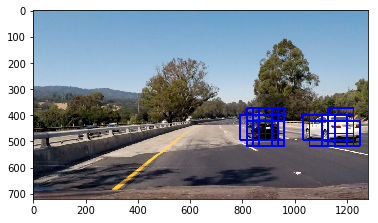

In [204]:
# Testing the find_cars function on a test image
# ystart, ystop, and scale values are the ones used in the lectures
ystart = 350
ystop = 650
scale = 1.5

# Load data from the pickle file
with open('svc1.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle
    
img = mpimg.imread('./test_images/test4.jpg')
out_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

**Multiple Dtetections**

In [205]:
# Increase the heatmap value at the points where a detection occured
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [206]:
# Apply a threshold to the heatmap, to filter out false positives
# (appearing only in a few of the considered frames)
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [207]:
# Draw boxes aound the detected objects
def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the image
    return img, bboxes

In [208]:
def apply_heat(img, box_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    _, car_bbox = draw_labeled_bboxes(np.copy(img), labels)
    return car_bbox

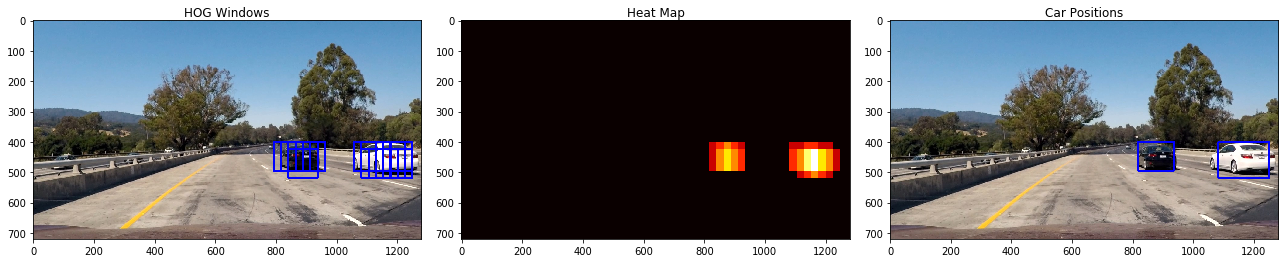

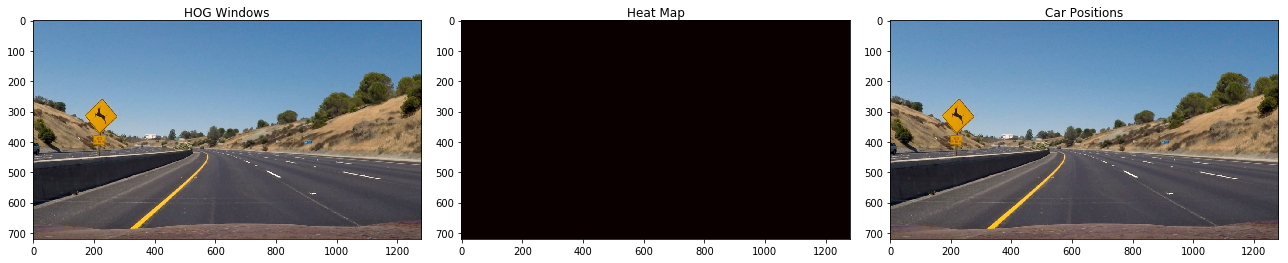

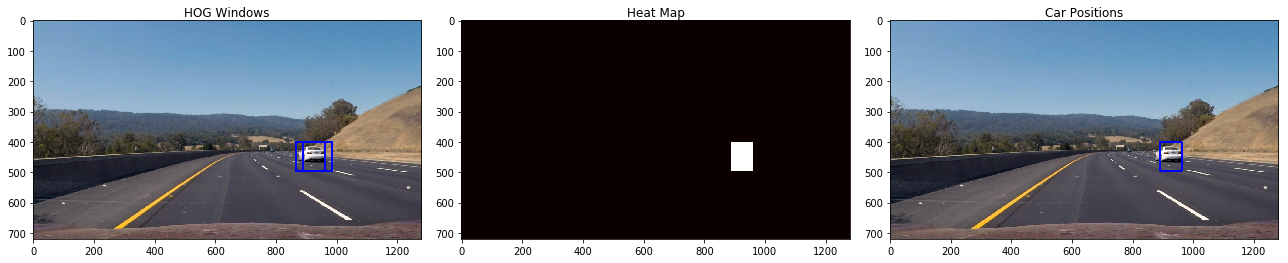

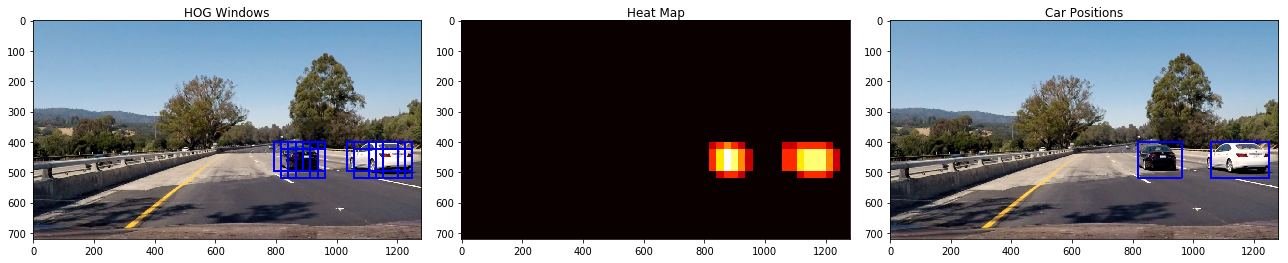

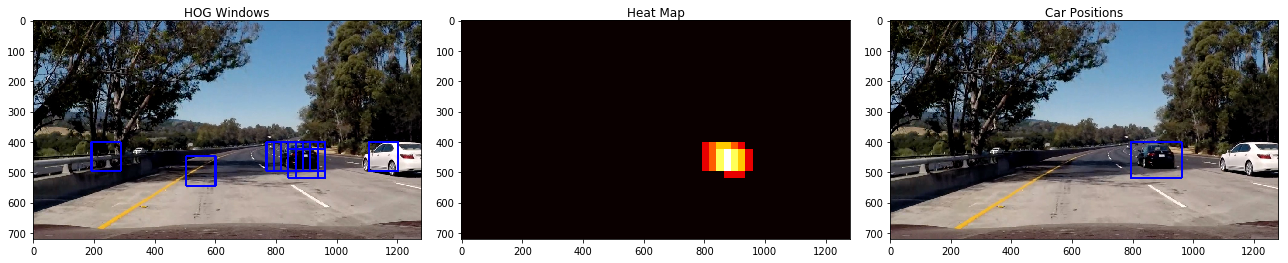

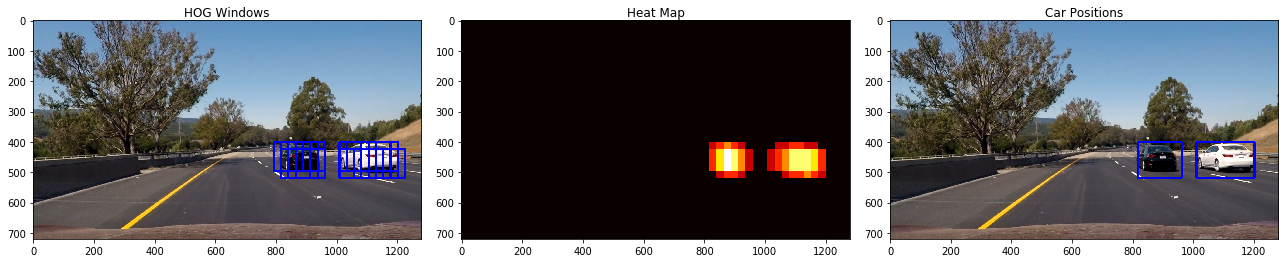

In [210]:
# Testing the find_cars function on all test images provided
images = glob.glob('./test_images/*.jpg')

# ystart, ystop, and scale values are the ones used in the lectures
ystart = 400
ystop = 650
scale = 1.5

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [450, None] # Min and max in y to search in slide_window()

# Load data from the pickle file
with open('svc1.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle


for image in images:
    img = mpimg.imread(image)
    
    out_img, box_list = find_cars(img, ystart, ystop, scale, 
                              svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, _ = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize=(18,8))
    plt.subplot(131), plt.imshow(out_img), plt.title('HOG Windows')
    plt.subplot(132), plt.imshow(heatmap, cmap='hot'), plt.title('Heat Map')
    plt.subplot(133), plt.imshow(draw_img), plt.title('Car Positions')
    fig.tight_layout()

In [236]:
# Define a class to receive the characteristics of each vehicle detection
# (Similar to the one for lane detection)
class Vehicle():
    def __init__(self):
        self.current_bboxes = []
        self.recent_bboxes = deque([], 6)
        self.img = None
        self.draw_img = None
        self.frame = 0
        self.new_ystop = 0

    def draw_over_frames(self, box_list):
        self.recent_bboxes.append(box_list)
        heat = np.zeros_like(self.img[:,:,0]).astype(np.float)
        for bbox_list in self.recent_bboxes:
            heat = add_heat(heat, bbox_list)
        heat = apply_threshold(heat, len(self.recent_bboxes)/3)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        self.draw_img, bbox = draw_labeled_bboxes(np.copy(self.img), labels)
        if np.array(bbox).any():
            self.current_bboxes = bbox
            self.new_ystop = np.amax(np.array(bbox), axis=0)[1,1] + 64
        else:
            self.new_ystop = 0
        return  self.draw_img

In [237]:
def pipeline(img, vehicles, y_start, y_stop, scales,
                 svc, X_scaler, orient, pix_per_cell,
                 cell_per_block, spatial_size, hist_bins):
    box_list = []
    vehicles.img = img
    if (vehicles.frame % 6 == 0):
        for ystart, ystop, scale in zip(y_start, y_stop, scales):
            _, boxes = find_cars(img, ystart, ystop, scale,
                         svc, X_scaler, orient, pix_per_cell,
                         cell_per_block, spatial_size, hist_bins)
            box_list.extend(boxes)
        bbox = apply_heat(img, box_list)
        draw_img = vehicles.draw_over_frames(bbox)
    else:
        draw_img = draw_boxes(img, vehicles.current_bboxes)

    vehicles.frame += 1

    return draw_img


In [238]:
with open('svc1.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle

y_start = [400, 400, 400, 400]
y_stop = [500, 550, 600, 650]
scales = [1.0, 1.25, 1.5, 1.75]
def process_image(img):
    return pipeline(img, vehicles, y_start, y_stop, scales,
                    svc, X_scaler, orient, pix_per_cell,
                    cell_per_block, spatial_size, hist_bins)

In [246]:
vehicles = Vehicle()
video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:12<00:00,  6.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2min 58s, sys: 11.3 s, total: 3min 9s
Wall time: 3min 13s


In [242]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

**Combine Vehicle detection with Advanced Lane Detection from Previous Assignment**

The video output from the previous assignment that already has the lane that we drive on marked, was fed as input to the vehicle detection pipeline.
It would be possible to process everything in one step, it was not performed here for simplicity reasons, since the video with the lane marked was already available.
Otherwise, there would have to be created a common pipeline, where the image returned from the lane finding pipeline would be the input to the vehicle detection pipeline, and the output would be the combined result.

In [244]:
vehicles = Vehicle()
combined_video_output = 'combined_project_video_output.mp4'
clip1 = VideoFileClip('combined_project_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(combined_video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:08<00:00,  6.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2min 55s, sys: 10.2 s, total: 3min 5s
Wall time: 3min 8s


In [245]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(combined_video_output))